# Polygonal Prisms

This code transform a list of prisms with vertices in polar coordinates into a list of classes of polygonal prisms using fatiando.

In [1]:
# Set PySide compatible APIs.
import sip
sip.setapi('QString', 2)
sip.setapi('QVariant', 2)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.gravmag import prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
import mag_polyprism_functions as mfun
import polyprism_tests as tests
% matplotlib inline

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


### Polygonal prisms

In [3]:
inc, dec = -60., 50. # inclination and declination of regional field
incs, decs = 70., -50.      # wrong direction or remanent

In [4]:
L = 10 # number of prisms
M = 8 # number of vertices

#r = 1000. # radial distance for each vertice
r = np.zeros(M)
r[::2] = 3000.
r[1::2] = np.sqrt(2.)*3000./2.

# Cartesian coordinates of the origin of each prism
x0 = np.zeros(L) + 1000.
y0 = np.zeros(L) + 1000.

dz = 300.0    # thickness of each prism

In [5]:
tests.test_volume()

In [6]:
props={'magnetization': utils.ang2vec(3, inc, dec)} # physical property

z0 = 100.0    # depth of the top the shallowest prism

m = []   # list of prisms

### creating the lis of prisms

for i in range(L):
    m.append([r, x0[i], y0[i], z0 + dz*i, z0 + dz*(i + 1), props])

In [7]:
model = mfun.pol2cart(m, M, L)

# Observation points

In [8]:
#area over which the data are calculated
#x minimum, x maximum, y minimum and y maximum
area = [-10000, 10000, -10000, 10000] 

#number of data along the y and x directions
shape = (80,80)

#total number of data
N = shape[0]*shape[1]

#coordinates x and y of the data
x = np.linspace(area[0],area[1],shape[0]) # points in x
y = np.linspace(area[2],area[3],shape[0]) # points in y
xp,yp = np.meshgrid(x,y)    # creating mesh points
xp = xp.ravel()
yp = yp.ravel()

#vertical coordinates of the data
zp = -350. - 500.*utils.gaussian2d(xp, yp, 17000, 21000, 21000, 18500, angle=21) # relief

### Total field anomaly (TFA) for polygonal prisms (fatiando)

In [9]:
tfat = polyprism.tf(xp, yp, zp, model, inc, dec)

In [10]:
model_recprism = [mesher.Prism(-3000, 3000, -3000, 3000, 100, 3100, props)]
    
tfat_recprism = prism.tf(xp, yp, zp, model_recprism, inc, dec)

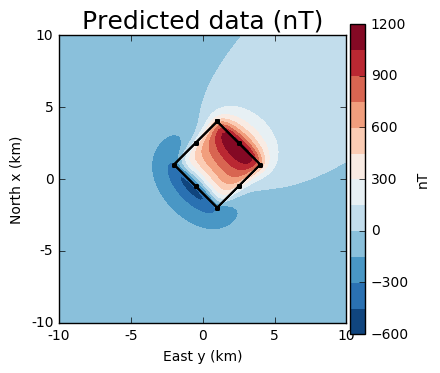

In [11]:
mpl.figure(figsize=(15,10))
mpl.subplot(1,3,1)
mpl.title("Predicted data (nT)", fontsize = 18)
mpl.axis('scaled')
nlevels = mpl.contourf(yp, xp, tfat,shape, 15, cmap='RdBu_r')
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.colorbar(pad=0.01, aspect=20, shrink=0.4).set_label('nT')
for p in model:
    mpl.polygon(p, '.-k', xy2ne=True)
mpl.m2km()
mpl.show()


In [12]:
delta = 500.
df_x = mfun.fd_tf_x0_polyprism(xp, yp, zp, m[4], M, delta, inc, dec)

In [13]:
df_y = mfun.fd_tf_y0_polyprism(xp, yp, zp, m[4], M, delta, inc, dec)

In [14]:
nv = 2
df_r = mfun.fd_tf_radial_polyprism(xp, yp, zp, m[4], M, nv, delta, inc, dec)

In [15]:
G = mfun.fd_tf_sm_polyprism(xp, yp, zp, m, M, L, delta, delta, delta, inc, dec)  #sensibility matrix

### Tests for TFA functions with finite differences

In [16]:
tests.test_volume()

In [17]:
tests.test_tfa_data()

In [18]:
tests.test_tfa_fd_x0_data()

In [19]:
tests.test_tfa_fd_y0_data()

In [20]:
#bounds = [-5000., 5000., -5000., 5000., 0.0, 1000.]

# Show the model
#scene = myv.figure()
#myv.polyprisms(mpt, 'magnetization')
#myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])

#scene.scene.camera.position = [-7807.4452530978979, -7807.4452530979024, -4486.7908303696386]
#scene.scene.camera.focal_point = [0.0, 0.0, 600.0]
#scene.scene.camera.view_angle = 30.0
#scene.scene.camera.view_up = [0.0, 0.0, -1.0]
#scene.scene.camera.clipping_range = [6256.115234984627, 19992.338744856861]
#scene.scene.camera.compute_view_plane_normal()
#scene.scene.render()

#myv.show()